# Book Recommendations

The goal of the project is to build a recommender system that suggests relevant books based on the person's interests.

## Collaborative filtering using `surprise` library: 

### Experiments with 10 different algorithms

Run cross-validation on the training set and compare the results to shortlist a few models.

In [1]:
# For reproducible experiments

import random
import numpy as np

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

In [2]:
import pandas as pd

from surprise import NormalPredictor, BaselineOnly
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering
from surprise import KNNBasic, KNNWithMeans, KNNBaseline, KNNWithZScore
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

## 1. Load and prepare the data

#### Read the training and test set into DataFrames

In [3]:
ratings_train = pd.read_csv('../data/ratings_train.csv')
ratings_test = pd.read_csv('../data/ratings_test.csv')

print(ratings_train.shape)
print(ratings_test.shape)

(5080007, 3)
(896472, 3)


In [4]:
ratings_train.head()

,user_id,book_id,rating
0,11231,786,3
1,13003,312,3
2,49878,92,4
3,17415,523,4
4,39041,3239,4


In [5]:
ratings_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5080007 entries, 0 to 5080006
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 116.3 MB


In [6]:
print(f"Number of users: {len(ratings_train['user_id'].unique())}")
print(f"Number of books: {len(ratings_train['book_id'].unique())}")

Number of users: 53424
Number of books: 10000


#### Create a `surprise` dataset for training data (load from the pandas DataFrame)

In [7]:
# Define a Reader object for Surprise to be able to parse the dataframe
reader = Reader(rating_scale=(1, 5))

# Load a dataset (columns in df must correspond to user id, item id and ratings in this order)
data = Dataset.load_from_df(ratings_train, reader)

In [8]:
data

## 2. Compare different algorithms (using training set)

Run 3-fold cross-validation for different algorithms (with default hyperparameters) and compare their performance.

Basic algorithms:

        2.1 Normal Predictor (Random)
        2.2 Baseline Only

Matrix Factorization-based algorithms:

        2.3 SVD
        2.4 SVD++
        2.5 NMF

    2.6 Slope One
    2.7 Co-Clustering

k-NN algorithms:

        2.8 k-NN Basic (item-based)
        2.9 k-NN with Means (item-based)
        2.10 k-NN Baseline (item-based)

More details about the `surprise` prediction algorithms: https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html

### 2.1 Normal Predictor (Random)

Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.

In [9]:
# Use cross-validation

normal_predictor_cv = cross_validate(NormalPredictor(), data, measures=['RMSE', 'MAE'], cv=3, 
                                     return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3233  1.3241  1.3229  1.3235  0.0005  
MAE (testset)     1.0503  1.0511  1.0504  1.0506  0.0004  
RMSE (trainset)   1.3231  1.3226  1.3240  1.3232  0.0006  
MAE (trainset)    1.0502  1.0499  1.0507  1.0503  0.0003  
Fit time          9.33    10.50   8.42    9.42    0.85    
Test time         35.85   34.85   25.49   32.06   4.67    


### 2.2 Baseline Only

Algorithm predicting the baseline estimate for given user and item.

In [10]:
baseline_only_cv = cross_validate(BaselineOnly(), data, measures=['RMSE', 'MAE'], cv=3, 
                                  return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8579  0.8590  0.8575  0.8581  0.0007  
MAE (testset)     0.6752  0.6761  0.6752  0.6755  0.0004  
RMSE (trainset)   0.8453  0.8447  0.8454  0.8451  0.0003  
MAE (trainset)    0.6654  0.6648  0.6655  0.6652  0.0003  
Fit time          5.18    5.84    4.15    5.06    0.70    
Test time         25.75   29.12   16.88   23.92   5.16    


### 2.3 SVD

The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. 

When baselines are not used, this is equivalent to Probabilistic Matrix Factorization (can be achieved by setting the `biased` parameter to `False`)

In [11]:
svd_cv = cross_validate(SVD(), data, measures=['RMSE', 'MAE'], cv=3, 
                        return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8498  0.8503  0.8501  0.8501  0.0002  
MAE (testset)     0.6594  0.6597  0.6594  0.6595  0.0001  
RMSE (trainset)   0.6455  0.6462  0.6456  0.6458  0.0003  
MAE (trainset)    0.5027  0.5033  0.5027  0.5029  0.0003  
Fit time          427.40  426.17  370.34  407.97  26.61   
Test time         33.53   35.09   27.40   32.01   3.32    


### 2.4 SVD++

The SVD++ algorithm, an extension of SVD taking into account implicit ratings. Here, an implicit rating describes the fact that a user rated an item, regardless of the rating value.

In [13]:
svdpp_cv = cross_validate(SVDpp(), data, measures=['RMSE', 'MAE'], cv=3, 
                          return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8324  0.8319  0.8315  0.8319  0.0004  
MAE (testset)     0.6421  0.6418  0.6415  0.6418  0.0002  
RMSE (trainset)   0.7072  0.7064  0.7074  0.7070  0.0004  
MAE (trainset)    0.5475  0.5472  0.5479  0.5476  0.0003  
Fit time          7011.98 6995.61 6181.07 6729.55 387.89  
Test time         261.71  260.95  192.48  238.38  32.46   


In [14]:
svdpp_cv

{'test_rmse': array([0.83241515, 0.83185636, 0.83153911]),
 'train_rmse': array([0.70717522, 0.70644077, 0.7073714 ]),
 'test_mae': array([0.64210933, 0.64175439, 0.64151114]),
 'train_mae': array([0.54754537, 0.54723361, 0.54793872]),
 'fit_time': (7011.979629516602, 6995.607023000717, 6181.073933362961),
 'test_time': (261.7084906101227, 260.95095443725586, 192.48142838478088)}

### 2.5 NMF

A collaborative filtering algorithm based on Non-negative Matrix Factorization. This algorithm is very similar to SVD. 

User and item factors are kept positive.

In [16]:
nmf_cv = cross_validate(NMF(), data, measures=['RMSE', 'MAE'], cv=3, 
                        return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8709  0.8710  0.8711  0.8710  0.0001  
MAE (testset)     0.6826  0.6828  0.6831  0.6828  0.0002  
RMSE (trainset)   0.7890  0.7900  0.7889  0.7893  0.0005  
MAE (trainset)    0.6180  0.6189  0.6180  0.6183  0.0004  
Fit time          434.69  438.56  386.60  419.95  23.64   
Test time         26.21   26.59   26.57   26.46   0.18    


### 2.6 Slope One

A simple yet accurate collaborative filtering algorithm.

In [19]:
slope_one_cv = cross_validate(SlopeOne(), data, measures=['RMSE', 'MAE'], cv=3, 
                              return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8511  0.8499  0.8503  0.8504  0.0005  
MAE (testset)     0.6623  0.6614  0.6618  0.6618  0.0003  
RMSE (trainset)   0.7105  0.7107  0.7108  0.7106  0.0001  
MAE (trainset)    0.5424  0.5427  0.5427  0.5426  0.0002  
Fit time          52.31   51.22   34.82   46.12   8.00    
Test time         188.75  187.09  147.42  174.42  19.10   


### 2.7 Co-clustering

A collaborative filtering algorithm based on co-clustering.

In [22]:
co_clustering_cv = cross_validate(CoClustering(), data, measures=['RMSE', 'MAE'], cv=3, 
                                  return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm CoClustering on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8684  0.8695  0.8672  0.8684  0.0009  
MAE (testset)     0.6746  0.6750  0.6734  0.6743  0.0007  
RMSE (trainset)   0.8372  0.8368  0.8368  0.8369  0.0002  
MAE (trainset)    0.6496  0.6493  0.6491  0.6493  0.0002  
Fit time          129.92  129.31  112.53  123.92  8.05    
Test time         25.41   26.02   20.98   24.14   2.24    


### 2.8 k-NN Basic

A basic collaborative filtering algorithm.

**Default: user-based filtering.**

Tried to run:
```
knn_basic_cv = cross_validate(KNNBasic(), data, measures=['RMSE', 'MAE'], cv=3, 
                              return_train_measures=True, n_jobs=2, verbose=True)
```

I got a memory error on my PC (there is a high number of users in the dataset):

"MemoryError: Unable to allocate 21.3 GiB for an array with shape (53424, 53424) and data type float64"

#### Try KNN Basic with item-based filtering (similarities between items are computed):

In [32]:
sim_options = {'user_based': False}  # compute similarities between items
knn_basic = KNNBasic(sim_options=sim_options)

knn_basic_items_cv = cross_validate(knn_basic, data, measures=['RMSE', 'MAE'], cv=3, 
                                    return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8762  0.8743  0.8741  0.8749  0.0010  
MAE (testset)     0.6807  0.6793  0.6790  0.6796  0.0008  
RMSE (trainset)   0.6995  0.7002  0.7000  0.6999  0.0003  
MAE (trainset)    0.5292  0.5294  0.5293  0.5293  0.0001  
Fit time          49.29   46.20   27.77   41.09   9.50    
Test time         341.79  338.36  302.52  327.56  17.76   


### 2.9 k-NN with Means (Centered k-NN): item-based

A basic collaborative filtering algorithm, taking into account the mean ratings.

In [34]:
sim_options = {'user_based': False}  # compute  similarities between items
knn_with_means_items = KNNWithMeans(sim_options=sim_options)

knn_with_means_items_cv = cross_validate(knn_with_means_items, data, measures=['RMSE', 'MAE'], cv=3, 
                                         return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8508  0.8505  0.8501  0.8505  0.0003  
MAE (testset)     0.6604  0.6605  0.6600  0.6603  0.0002  
RMSE (trainset)   0.6895  0.6895  0.6898  0.6896  0.0001  
MAE (trainset)    0.5248  0.5246  0.5248  0.5247  0.0001  
Fit time          51.11   50.40   32.23   44.58   8.74    
Test time         379.23  381.04  333.01  364.43  22.23   


### Save the results (9 algorithms)

Create a DataFrame with the average RMSE and MAE of various algorithms on a 3-fold cross-validation procedure. 

In [36]:
algorithms = ['Normal Predictor (Random)', 'Baseline Only', 'SVD', 'SVD++', 'NMF', 
              'Slope One', 'Co-Clustering', 'k-NN Basic (item-based)', 
              'k-NN with Means (item-based)']

# A list with results for all algorithms
cv_results = [normal_predictor_cv, baseline_only_cv, svd_cv, svdpp_cv, nmf_cv, 
              slope_one_cv, co_clustering_cv, knn_basic_items_cv, knn_with_means_items_cv]

# Average RMSE and MAE (validation and training)
avg_val_rmse = [np.mean(result['test_rmse']) for result in cv_results]
avg_val_mae = [np.mean(result['test_mae']) for result in cv_results]
avg_train_rmse = [np.mean(result['train_rmse']) for result in cv_results]
avg_train_mae = [np.mean(result['train_mae']) for result in cv_results]

df_cv_results = pd.DataFrame({
    'algorithm': algorithms, 
    'avg_val_rmse': avg_val_rmse, 
    'avg_val_mae': avg_val_mae, 
    'avg_train_rmse': avg_train_rmse, 
    'avg_train_mae': avg_train_mae,
})

df_cv_results

,algorithm,avg_val_rmse,avg_val_mae,avg_train_rmse,avg_train_mae
0,Normal Predictor (Random),1.323466,1.050609,1.323242,1.050296
1,Baseline Only,0.858144,0.675506,0.845130,0.665202
2,SVD,0.850060,0.659465,0.645765,0.502873
3,SVD++,0.831937,0.641792,0.706996,0.547573
4,NMF,0.870976,0.682822,0.789268,0.618320
5,Slope One,0.850398,0.661817,0.710634,0.542606
6,Co-Clustering,0.868356,0.674346,0.836897,0.649331
7,k-NN Basic (item-based),0.874876,0.679643,0.699901,0.529300
8,k-NN with Means (item-based),0.850480,0.660333,0.689567,0.524732


Save as a csv file:

In [37]:
df_cv_results.to_csv('../data/collaborative_filtering_cv_results.csv', index=False)

**Next day: Tried one more algorithm**

### 2.10 k-NN Baseline: item-based

A basic collaborative filtering algorithm taking into account a baseline rating.

In [9]:
sim_options = {'user_based': False}  # compute  similarities between items
knn_baseline_items = KNNBaseline(sim_options=sim_options)

knn_baseline_items_cv = cross_validate(knn_baseline_items, data, measures=['RMSE', 'MAE'], cv=3, 
                                       return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8468  0.8470  0.8470  0.8469  0.0001  
MAE (testset)     0.6569  0.6568  0.6567  0.6568  0.0001  
RMSE (trainset)   0.6855  0.6851  0.6852  0.6853  0.0002  
MAE (trainset)    0.5201  0.5201  0.5201  0.5201  0.0000  
Fit time          53.16   46.34   30.24   43.25   9.61    
Test time         495.24  489.99  396.11  460.45  45.54   


Add these results to the csv file created earlier:

In [10]:
knn_baseline_cv_result = [
    np.mean(knn_baseline_items_cv['test_rmse']), 
    np.mean(knn_baseline_items_cv['test_mae']), 
    np.mean(knn_baseline_items_cv['train_rmse']), 
    np.mean(knn_baseline_items_cv['train_mae'])
]

knn_baseline_cv_result_string = ','.join([str(i) for i in knn_baseline_cv_result])
knn_baseline_cv_result_string

'0.846910013146017,0.6567634132649346,0.6852818338263172,0.5200787250638058'

In [13]:
with open('../data/collaborative_filtering_cv_results.csv', 'a') as f:
    f.write(f'k-NN Baseline (item-based),{knn_baseline_cv_result_string}\n')

### Compare all cross-validation results (10 algorithms):

In [14]:
df_cv_results_all = pd.read_csv('../data/collaborative_filtering_cv_results.csv')
df_cv_results_all

,algorithm,avg_val_rmse,avg_val_mae,avg_train_rmse,avg_train_mae
0,Normal Predictor (Random),1.323466,1.050609,1.323242,1.050296
1,Baseline Only,0.858144,0.675506,0.845130,0.665202
2,SVD,0.850060,0.659465,0.645765,0.502873
3,SVD++,0.831937,0.641792,0.706996,0.547573
4,NMF,0.870976,0.682822,0.789268,0.618320
5,Slope One,0.850398,0.661817,0.710634,0.542606
6,Co-Clustering,0.868356,0.674346,0.836897,0.649331
7,k-NN Basic (item-based),0.874876,0.679643,0.699901,0.529300
8,k-NN with Means (item-based),0.850480,0.660333,0.689567,0.524732
9,k-NN Baseline (item-based),0.846910,0.656763,0.685282,0.520079


### Conclusions:
- SVD++ showed the best performance (and took the longest time to run cross-validation out of all algorithms). 
- For k-NN Baseline (item-based), SVD, Slope One and k-NN with Means (item-based) - also good results. From these algorithms, the Slope One was the fastest.

## 3. Tune the SVD++ hyperparameters with GridSearchCV

#### Grid Search 1:

In [15]:
param_grid_1 = {'n_epochs': [10], 
                'n_factors': [20, 30], 
                'lr_all': [0.005, 0.01], 
                'reg_all': [0.08, 0.2]}

gs_svdpp_1 = GridSearchCV(SVDpp, param_grid_1, measures=['rmse', 'mae'], cv=2, n_jobs=2)

gs_svdpp_1.fit(data)

In [17]:
# best RMSE score
print(gs_svdpp_1.best_score['rmse'])

0.8565178594908749


In [18]:
# best MAE score
print(gs_svdpp_1.best_score['mae'])

0.6706129575111912


In [19]:
# combination of parameters that gave the best RMSE score
print(gs_svdpp_1.best_params['rmse'])

{'n_epochs': 10, 'n_factors': 30, 'lr_all': 0.01, 'reg_all': 0.08}


In [20]:
# combination of parameters that gave the best MAE score
print(gs_svdpp_1.best_params['mae'])

{'n_epochs': 10, 'n_factors': 30, 'lr_all': 0.01, 'reg_all': 0.08}


In [21]:
gs_results_1 = pd.DataFrame.from_dict(gs_svdpp_1.cv_results)
gs_results_1

,split0_test_rmse,split1_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_n_factors,param_lr_all,param_reg_all
0,0.860043,0.860983,0.860513,0.000470,3,0.676145,0.676607,0.676376,0.000231,3,2067.264136,5.612980,302.820371,0.555896,"{'n_epochs': 10, 'n_factors': 20, 'lr_all': 0....",10,20,0.005,0.08
1,0.863106,0.864024,0.863565,0.000459,7,0.681323,0.681747,0.681535,0.000212,7,2296.753699,4.383607,303.318483,1.544593,"{'n_epochs': 10, 'n_factors': 20, 'lr_all': 0....",10,20,0.005,0.20
2,0.856635,0.858638,0.857636,0.001002,2,0.670860,0.672016,0.671438,0.000578,2,2077.593564,3.181680,287.236995,0.557971,"{'n_epochs': 10, 'n_factors': 20, 'lr_all': 0....",10,20,0.010,0.08
3,0.861989,0.863061,0.862525,0.000536,6,0.678586,0.679045,0.678816,0.000230,5,1932.945023,0.999708,252.426914,1.689198,"{'n_epochs': 10, 'n_factors': 20, 'lr_all': 0....",10,20,0.010,0.20
4,0.860071,0.861014,0.860542,0.000471,4,0.676220,0.676680,0.676450,0.000230,4,3098.634207,10.937253,308.524674,0.806571,"{'n_epochs': 10, 'n_factors': 30, 'lr_all': 0....",10,30,0.005,0.08
5,0.863129,0.864054,0.863591,0.000463,8,0.681349,0.681789,0.681569,0.000220,8,2339.477973,0.043872,245.553543,0.566900,"{'n_epochs': 10, 'n_factors': 30, 'lr_all': 0....",10,30,0.005,0.20
6,0.856318,0.856718,0.856518,0.000200,1,0.670636,0.670590,0.670613,0.000023,1,2769.687194,11.633746,322.447543,3.359383,"{'n_epochs': 10, 'n_factors': 30, 'lr_all': 0....",10,30,0.010,0.08
7,0.861987,0.863052,0.862520,0.000533,5,0.678593,0.679048,0.678820,0.000228,6,2674.785605,6.705252,269.516306,5.160377,"{'n_epochs': 10, 'n_factors': 30, 'lr_all': 0....",10,30,0.010,0.20


Choose lr_all = 0.01.

30 Factors is quite high number and it would be difficult to interpret so many factors. I will check smaller numbers later.

Next step: to tune reg_all.

#### Grid Search 2:

In [22]:
param_grid_2 = {'n_epochs': [10], 
                'n_factors': [20], 
                'lr_all': [0.01], 
                'reg_all': [0.02, 0.04]}

gs_svdpp_2 = GridSearchCV(SVDpp, param_grid_2, measures=['rmse', 'mae'], cv=2, n_jobs=2)

gs_svdpp_2.fit(data)

In [23]:
# best MAE score
print(gs_svdpp_2.best_score['mae'])

0.6535525469937704


In [24]:
# combination of parameters that gave the best MAE score
print(gs_svdpp_2.best_params['mae'])

{'n_epochs': 10, 'n_factors': 20, 'lr_all': 0.01, 'reg_all': 0.02}


In [25]:
gs_results_2 = pd.DataFrame.from_dict(gs_svdpp_2.cv_results)
gs_results_2

,split0_test_rmse,split1_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_n_factors,param_lr_all,param_reg_all
0,0.84083,0.840871,0.840851,0.000020,1,0.653148,0.653957,0.653553,0.000404,1,2126.315833,14.653890,286.613644,2.514282,"{'n_epochs': 10, 'n_factors': 20, 'lr_all': 0....",10,20,0.01,0.02
1,0.84566,0.845670,0.845665,0.000005,2,0.659548,0.660152,0.659850,0.000302,2,2230.852666,7.216616,288.027153,1.789262,"{'n_epochs': 10, 'n_factors': 20, 'lr_all': 0....",10,20,0.01,0.04


Choose reg_all = 0.02

#### Grid Search 3 (explore n_factors):

In [9]:
param_grid_3 = {'n_epochs': [10], 
                'n_factors': [4, 8, 12, 16], 
                'lr_all': [0.01], 
                'reg_all': [0.02]}

gs_svdpp_3 = GridSearchCV(SVDpp, param_grid_3, measures=['rmse', 'mae'], cv=2, n_jobs=2)

gs_svdpp_3.fit(data)

In [12]:
# combination of parameters that gave the best MAE score
print(gs_svdpp_3.best_params['mae'])

{'n_epochs': 10, 'n_factors': 16, 'lr_all': 0.01, 'reg_all': 0.02}


In [14]:
gs_results_3 = pd.DataFrame.from_dict(gs_svdpp_3.cv_results)
gs_results_3

,split0_test_rmse,split1_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_n_factors,param_lr_all,param_reg_all
0,0.840112,0.841907,0.841009,0.000897,4,0.653773,0.655035,0.654404,0.000631,4,1297.600780,1.818793,299.728889,0.427801,"{'n_epochs': 10, 'n_factors': 4, 'lr_all': 0.0...",10,4,0.01,0.02
1,0.839758,0.840256,0.840007,0.000249,2,0.653335,0.653203,0.653269,0.000066,3,1394.459228,1.441522,262.009202,0.146604,"{'n_epochs': 10, 'n_factors': 8, 'lr_all': 0.0...",10,8,0.01,0.02
2,0.839841,0.840149,0.839995,0.000154,1,0.653376,0.653008,0.653192,0.000184,2,1602.726772,2.839012,302.321278,0.475336,"{'n_epochs': 10, 'n_factors': 12, 'lr_all': 0....",10,12,0.01,0.02
3,0.839817,0.840535,0.840176,0.000359,3,0.653154,0.653173,0.653163,0.000009,1,2254.743243,7.953137,365.390478,0.847100,"{'n_epochs': 10, 'n_factors': 16, 'lr_all': 0....",10,16,0.01,0.02


Compare the mean validation MAE for different number of factors:

In [33]:
mean_test_mae_3 = pd.Series(gs_results_3['mean_test_mae'].values, name='mean_test_mae', 
                          index=pd.Index(gs_results_3['param_n_factors'], name='num_factors'))
mean_test_mae_3

num_factors
4     0.654404
8     0.653269
12    0.653192
16    0.653163
Name: mean_test_mae, dtype: float64

<AxesSubplot:xlabel='num_factors'>

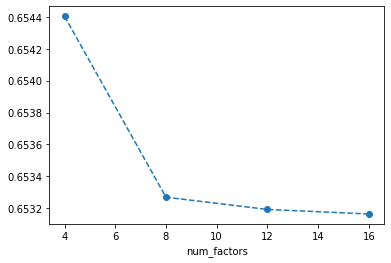

In [35]:
mean_test_mae_3.plot(style='o--')

#### Grid Search 4 (explore n_factors):

In [36]:
param_grid_4 = {'n_epochs': [10], 
                'n_factors': [5, 6, 7, 9, 10, 11], 
                'lr_all': [0.01], 
                'reg_all': [0.02]}

gs_svdpp_4 = GridSearchCV(SVDpp, param_grid_4, measures=['rmse', 'mae'], cv=2, n_jobs=2)

gs_svdpp_4.fit(data)

In [37]:
# combination of parameters that gave the best MAE score
print(gs_svdpp_4.best_params['mae'])

{'n_epochs': 10, 'n_factors': 11, 'lr_all': 0.01, 'reg_all': 0.02}


In [38]:
gs_results_4 = pd.DataFrame.from_dict(gs_svdpp_4.cv_results)
gs_results_4

,split0_test_rmse,split1_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_n_factors,param_lr_all,param_reg_all
0,0.841190,0.842028,0.841609,0.000419,6,0.654876,0.654926,0.654901,0.000025,6,1266.179453,3.023142,268.571121,3.064671,"{'n_epochs': 10, 'n_factors': 5, 'lr_all': 0.0...",10,5,0.01,0.02
1,0.840653,0.840327,0.840490,0.000163,2,0.654237,0.653285,0.653761,0.000476,2,1342.831069,1.849312,284.208439,0.343243,"{'n_epochs': 10, 'n_factors': 6, 'lr_all': 0.0...",10,6,0.01,0.02
2,0.839692,0.841481,0.840587,0.000895,3,0.653401,0.654345,0.653873,0.000472,4,1398.500218,0.457324,301.229504,0.327232,"{'n_epochs': 10, 'n_factors': 7, 'lr_all': 0.0...",10,7,0.01,0.02
3,0.840126,0.841397,0.840762,0.000636,5,0.653708,0.654135,0.653921,0.000213,5,1488.465553,4.426137,302.749080,0.558896,"{'n_epochs': 10, 'n_factors': 9, 'lr_all': 0.0...",10,9,0.01,0.02
4,0.840549,0.840833,0.840691,0.000142,4,0.654024,0.653665,0.653844,0.000179,3,1592.085426,0.040029,303.937923,0.983199,"{'n_epochs': 10, 'n_factors': 10, 'lr_all': 0....",10,10,0.01,0.02
5,0.839558,0.840756,0.840157,0.000599,1,0.652981,0.653398,0.653190,0.000208,1,1646.917433,0.602426,302.496402,0.366261,"{'n_epochs': 10, 'n_factors': 11, 'lr_all': 0....",10,11,0.01,0.02


Compare the mean validation MAE for different number of factors:

In [40]:
mean_test_mae_4 = pd.Series(gs_results_4['mean_test_mae'].values, name='mean_test_mae', 
                            index=pd.Index(gs_results_4['param_n_factors'], name='num_factors'))
mean_test_mae_4

num_factors
5     0.654901
6     0.653761
7     0.653873
9     0.653921
10    0.653844
11    0.653190
Name: mean_test_mae, dtype: float64

<AxesSubplot:xlabel='num_factors'>

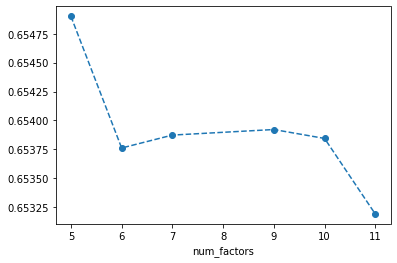

In [42]:
mean_test_mae_4.plot(style='o--')

Combine the results from grid searches 3 and 4:

In [50]:
concat_test_mae = pd.concat([mean_test_mae_3, mean_test_mae_4]).sort_index()
concat_test_mae

num_factors
4     0.654404
5     0.654901
6     0.653761
7     0.653873
8     0.653269
9     0.653921
10    0.653844
11    0.653190
12    0.653192
16    0.653163
Name: mean_test_mae, dtype: float64

<AxesSubplot:xlabel='num_factors'>

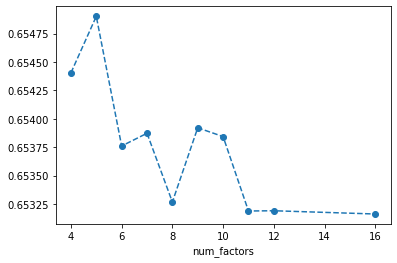

In [51]:
# Mean validation MAE
# The lowest values are for number of factors 8, 11 and greater than 11

concat_test_mae.plot(style='o--')

Choose num_factors = 8

#### Grid Search 5 (select n_epochs):

In [52]:
param_grid_5 = {'n_epochs': [15, 20, 25], 
                'n_factors': [8], 
                'lr_all': [0.01], 
                'reg_all': [0.02]}

gs_svdpp_5 = GridSearchCV(SVDpp, param_grid_5, measures=['rmse', 'mae'], cv=2, n_jobs=2)

gs_svdpp_5.fit(data)

In [55]:
# best MAE score
print(gs_svdpp_5.best_score['mae'])

0.6517469650500047


In [56]:
# combination of parameters that gave the best MAE score
print(gs_svdpp_5.best_params['mae'])

{'n_epochs': 15, 'n_factors': 8, 'lr_all': 0.01, 'reg_all': 0.02}


In [57]:
gs_results_5 = pd.DataFrame.from_dict(gs_svdpp_5.cv_results)
gs_results_5

,split0_test_rmse,split1_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_n_factors,param_lr_all,param_reg_all
0,0.841514,0.841718,0.841616,0.000102,1,0.651249,0.652245,0.651747,0.000498,1,2344.329885,5.977741,262.652161,0.387275,"{'n_epochs': 15, 'n_factors': 8, 'lr_all': 0.0...",15,8,0.01,0.02
1,0.846779,0.846887,0.846833,0.000054,2,0.652649,0.653659,0.653154,0.000505,2,2808.220288,3.296838,261.978684,0.005004,"{'n_epochs': 20, 'n_factors': 8, 'lr_all': 0.0...",20,8,0.01,0.02
2,0.852610,0.853364,0.852987,0.000377,3,0.655196,0.656258,0.655727,0.000531,3,3627.402585,11.244469,258.892004,0.021524,"{'n_epochs': 25, 'n_factors': 8, 'lr_all': 0.0...",25,8,0.01,0.02


### Chosen hyperparameters for SVD++:
- n_epochs = 15
- n_factors = 8
- lr_all = 0.01
- reg_all = 0.02

Mean validation MAE = 0.652

Mean validation RMSE = 0.842